# Lasso with reduced feature space
- WGCNA was used to cluster the transcription data
- account for multicolinearity

In [1]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler as zscore # zscore
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso #LRlasso
from joblib import dump, load #to save models in files
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import json
from datetime import datetime
import os

### Piplines from the python scripts 

In [2]:

from sklearn.model_selection import GridSearchCV
def gridcv(X, y, model, param_grid, naimpute=False, prepy=True, scorer = 'neg_mean_squared_error', cv_meth = LeaveOneOut(), cv_n_jobs = 1):
    """
    Perform Cross-Validation (defaukt: LOOCV) with hyperparameter tuning using GridSearchCV.
    
    Parameters:
    ----------
    X : pandas DataFrame or numpy array
        The feature matrix.
        
    y : pandas Series or numpy array
        The target variable.
        
    model : scikit-learn estimator
        The machine learning model to be used, should be an uninitialized model instance 
        (e.g., Lasso(), not Lasso(alpha=1.0)).
        
    param_grid : dict
        Dictionary containing the hyperparameters to be tuned and their possible values. 
        The keys should be prefixed with 'regressor__' to work with the pipeline.
        
    naimpute : bool, optional (default=False)
        Toggle imputation for missing values. 
        Currently not implemented; will print a message and return 0 if set to True.
        
    prepy : bool, optional (default=True)
        Toggle preprocessing target variable 'y' by setting any negative values to zero.
        
    scorer : str, callable, or None, optional (default='neg_mean_squared_error')
        A string or a scorer callable object / function with signature scorer(estimator, X, y). 
        For valid scoring strings, see the scikit-learn documentation.
        
    cv_meth : cross-validation generator, optional (default=LeaveOneOut())
        A cross-validation splitting strategy. 
        Possible inputs for cv are integers to specify the number of folds in a (Stratified)KFold, 
        CV splitter, cross-validation generator iterators, or an iterable.
        
    Returns:
    -------
    overall_metric : dict
        Dictionary containing the overall metrics and other details from the GridSearchCV.
        
    out_model : GridSearchCV object
        Fitted GridSearchCV object.
        
    best_params : dict
        Dictionary containing the best hyperparameters found by GridSearchCV.

    Call:
    ------
    from sklearn.model_selection import KFold

    # set up KFold cross-validator
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    param_grid = {
        'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
        'regressor__fit_intercept': [True, False]
    }
    print(param_grid)

    # Call the gridcv function with KFold as the cross-validation method
    lasso_fullkfold_scores, lasso_fullkfold_model, best_param = gridcv(
        X, 
        y,
        Lasso(max_iter=4000),
        param_grid,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    dump(lasso_fullkfold_model, './models/lasso_fullkfold_model.pkl') # save the model as .pkl
    """

    # overall_metric = {'CV': cv_meth, 'scoring_metric': scorer} originally
    overall_metric = {'CV': str(cv_meth), 'scoring_metric': str(scorer)} # transformed to string because json dump scores later

    if prepy:
        y[y < 0] = 0
    
    if naimpute:
      print("not implemented")
      return 0


    pipeline = Pipeline([
        ('scaler', zscore()), 
        ('regressor', model)        # Regression model
    ])

    
    # declaring an Grid object
    # score : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    out_model = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_meth, scoring=scorer, n_jobs=cv_n_jobs).fit(X,y)
    # GridSearchCV need the regressor__ prefix for the pipiline object in the para_grid later when called

    best_pipeline = out_model.best_estimator_
    y_pred = best_pipeline.predict(X)

    overall_metric['correlation_true_pred'] = list(np.corrcoef(list(y), list(y_pred)))
    overall_metric['correlation_true_pred'][0] = list(overall_metric['correlation_true_pred'][0])
    overall_metric['correlation_true_pred'][1] = list(overall_metric['correlation_true_pred'][1])


    # LOOCV folds: split{i}_test_score (number of data points minus one) 
    overall_metric['fold_scores'] = [out_model.cv_results_[f'split{i}_test_score'][out_model.best_index_] for i in range(out_model.n_splits_)]
    best_params = out_model.best_params_


    # access the 'regressor' step from the best pipeline and then its coefficients
    coefficients = best_pipeline.named_steps['regressor'].coef_
    overall_metric['non_zero_coefficients'] = coefficients[coefficients != 0]
    overall_metric['non_zero_coefficients'] = overall_metric['non_zero_coefficients'].tolist()
    overall_metric['non_zero_features'] = list(X.columns[np.where(coefficients != 0)[0]])

    # printing section
    print("best parameter from gridsearch>>\n", out_model.best_params_)
    print(overall_metric['CV'])
    print(overall_metric['scoring_metric'])
    print("correlation Matrix>>\n", overall_metric['correlation_true_pred'])
    print("non_zero_features>>\n",overall_metric['non_zero_features'])
    print("scores for each fold>>\n",overall_metric['fold_scores'])

    return overall_metric, out_model, best_params


In [3]:

def nX_cross_validation(X, target, param_grid, scorer_estimate, output_prefix, random_states, output_path='./models/10xKfold/', n_splits=3, cv_n_jobs=1):
    if os.path.exists(output_path):
        print(f"The path {output_path} exists.")
    else:
        print(f"The path {output_path} does not exist.")
        raise FileNotFoundError(f"The path {output_path} does not exist.")
    best_fold_mean = float('-inf')
    best_model = []
    #cv_results = {'random_state': [], 'scores': {}, 'mean_scores': [], 'common_features': {}, 'model': {}}
    cv_results = {'random_state': [], 'scores': {}, 'mean_scores': [], 'selected_features': {}, 'best_param': []}
    for ran_state in random_states:
        print(ran_state)
        kfold_cv = KFold(n_splits=n_splits, shuffle=True, random_state=ran_state)
        scores, model, best_param = gridcv(
            X, 
            target,
            Lasso(max_iter=8000),
            param_grid,
            prepy=False,
            scorer=scorer_estimate, 
            cv_meth=kfold_cv,
            cv_n_jobs=cv_n_jobs
        )
        cv_results['random_state'].append(ran_state)
        cv_results['scores'][ran_state] = scores
        cv_results['mean_scores'].append(np.mean(scores['fold_scores']))
        if best_fold_mean == -100:
            best_fold_mean = np.mean(scores['fold_scores'])
            cv_results['best_param'] = best_param, ran_state, np.mean(scores['fold_scores'])
        elif best_fold_mean < np.mean(scores['fold_scores']):
            best_fold_mean = np.mean(scores['fold_scores'])
            cv_results['best_param'] = best_param, ran_state, np.mean(scores['fold_scores'])


        # cv_results['model'][ran_state] = model

    # Determine common features...
    #cv_results['common_features'] = set(cv_results['scores'][42]['non_zero_features'])
    #for r in cv_results['random_state'][1:]:
    #    current_features = set(cv_results['scores'][r]['non_zero_features'])
    #    cv_results['common_features'] = cv_results['common_features'].intersection(current_features)
    #cv_results['common_features'] = list(cv_results['common_features'])
    print(f"best estimator>>\n found in split: {cv_results['best_param'][1]}\n param_grid: {cv_results['best_param'][0]}\n mean fold score {cv_results['best_param'][2]}")    
    best_model = Lasso(alpha=cv_results['best_param'][0]['regressor__alpha'], fit_intercept=cv_results['best_param'][0]['regressor__fit_intercept']).fit(X, target)
    cv_results['selected_features'] = list(X.columns[np.where(best_model.coef_ != 0)[0]])
    #save to json
    with open(f"{output_path}{output_prefix}_nXcv.json", 'w') as file:
       json.dump(cv_results, file)
    file.close()

    return cv_results


In [4]:
def to_valid_variable_name(name):
    # Replace special characters with underscores
    name = re.sub(r'\W|^(?=\d)', '_', name)
    # Reduce multiple consecutive underscores to one
    name = re.sub(r'_{2,}', '_', name)
    # Truncate length if necessary
    max_length = 30
    if len(name) > max_length:
        name = name[:max_length]
    # Ensure it doesn't start with a number
    if name[0].isdigit():
        name = "_" + name
    return name


In [5]:
#gcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")
#lcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/lcms_mut.csv", sep=",")
gcms_mut = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")
lcms_mut = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/lcms_mut.csv", sep=",")



In [6]:
X = pd.read_csv("/work/yhesse/PW_rawdata/tr_gc_mutual/tr_wgcna_MEs.csv", sep=",", index_col=0)
X.head()


,MEdarkred,MEsalmon,MEsienna,MEdarkgrey,MEchocolate,MElightsalmon,MErosybrown,MEred,MEsaddlebrown,MEblack,MEmaroon,MEtomato,MEperu,MElinen,MEorangered,MEmistyrose,MEdimgrey,MEseashell
ref,,,,,,,,,,,,,,,,,,
Xe_De_R2_T00,-0.070542,-0.076521,-0.036572,0.273065,-0.063839,0.104769,-0.069150,-0.026775,0.142589,-0.095037,-0.025330,0.155800,0.087210,0.335986,0.072189,-0.121119,-0.098802,-0.143420
Xe_De_R2_T03,0.660550,0.047808,-0.036807,0.017875,0.000776,0.033626,0.122773,0.050396,0.269496,0.099744,-0.033325,0.074530,-0.039596,-0.040912,-0.194549,-0.011116,-0.168250,-0.127068
Xe_De_R2_T06,0.135545,0.240469,0.044559,0.038486,0.337999,0.101275,0.353547,0.583660,0.233476,0.204601,0.083258,-0.067397,-0.371903,-0.414662,-0.220544,-0.043053,-0.138183,-0.177591
Xe_De_R2_T09,-0.010512,0.006573,-0.030147,-0.068341,0.128373,0.098445,0.256827,0.139581,0.075497,0.019816,0.178133,0.111921,-0.104833,-0.068798,0.036791,-0.034521,-0.146483,-0.129996
Xe_De_R2_T12,0.029663,0.192380,-0.222354,-0.147784,-0.191662,-0.138411,-0.049868,-0.013878,-0.033662,-0.055919,0.091908,0.196573,-0.093520,-0.077363,0.015746,0.421891,-0.109746,0.176336


In [7]:
gcms_target_dict = {}
for target in gcms_mut['metabolite']:
    o = to_valid_variable_name(target)
    #print(f"{o} == \t {target}")
    gcms_target_dict[o] = str(target)


lcms_target_dict = {}
for target in lcms_mut['metabolite']:
    o = to_valid_variable_name(target)
    #print(f"{o} == \t {target}")
    lcms_target_dict[o] = str(target)
        

In [47]:
np.logspace(-4, 1, 20)
##old grid
#param_grid = {
#    'regressor__alpha': np.array(np.arange(0.0125, 0.0625, 0.0025)),
#    'regressor__fit_intercept': [True, False]
#}

array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])

In [8]:
param_grid = {
    'regressor__alpha': np.logspace(-4, 1, 20),
    'regressor__fit_intercept': [True]
}
cpus = 10
tenX = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
print(f"parameter grid >>\n {param_grid}")


parameter grid >>
 {'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  , 0.0425, 0.045 , 0.0475, 0.05  ,
       0.0525, 0.055 , 0.0575, 0.06  ]), 'regressor__fit_intercept': [True, False]}


In [10]:
out = '/work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/'

print(f"parameter grid >>\n {param_grid}")

for i, (gcms_target, orig_str) in enumerate(gcms_target_dict.items()):
    now = datetime.now()
    print(f"\n>> START {gcms_target} {now.isoformat()} <<")
    tmp_10xKfold = nX_cross_validation(X.iloc[:,:], gcms_mut.iloc[i,1:], param_grid, 'r2', str(gcms_target), random_states=tenX, output_path=out, cv_n_jobs=cpus)
    print(f"\n>> DONE <<\n\n")

with open(f"{out}gcms_dict_nXcv.json", 'w') as file:
    json.dump(gcms_target_dict, file)



>> START _6_phospho_gluconate 2024-01-23T11:48:10.095145 <<
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.025, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.7573058594815274], [0.7573058594815274, 0.9999999999999998]]
non_zero_features>>
 ['MEsalmon', 'MEsienna', 'MEblack', 'MEmaroon', 'MEperu', 'MEorangered', 'MEmistyrose', 'MEseashell']
scores for each fold>>
 [0.263697898774106, -0.3343199569779587, 0.4488517406698095]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.7822470896754982], [0.7822470896754982, 1.0]]
non_zero_features>>
 ['MEsalmon', 'MEsienna', 'MEred', 'MEblack', 'MElinen', 'MEorangered', 'MEmistyrose', 'MEseashell']
scores for each fold>>
 [0.32590833858523793, 0.43045150420706024, 0.573145

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0012374147333262808, -2.1281655788518705e-05, -0.001559691097752669]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.0325, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.023220734188736936, -0.3306811828028573, -0.22749751604275503]
46


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.037500000000000006, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.09606923286802838, -0.10587760810816049, -0.010003908861815347]
47
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0006717887728375782, -0.012556518790938886, -0.017762822480318574]
48


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= st

best parameter from gridsearch>>
 {'regressor__alpha': 0.030000000000000002, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.11120189447255413, -0.02916428523071035, -0.001424093371146018]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.23471083905619117, -0.0008062651982543301, -0.11573100891830457]
50
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.009569719342555683, -0.03385487019979827, -0.3220628690678293]
51


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.18163643115468875, -0.11761835952343636, -0.021653333079390436]
52
best parameter from gridsearch>>
 {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.1862037095664919, -0.011030989253465018, -0.11500876767084733]
best estimator>>
 found in split: 42
 param_grid: {'regressor__alpha': 0.020000000000000004, 'regressor__fit_intercept': True}
 mean fold score 0.021868702105543075

>> DONE <<



>> START asparagine_188_216_rt7_84 2024-01-23T11:48:22.980256 <<
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/ exists.
42
best parameter from gridsearch>>
 {'r

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.40824587316601746, -0.005327480584104816, -0.1941242107777068]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.36381130573783715], [0.36381130573783715, 1.0]]
non_zero_features>>
 ['MEsalmon']
scores for each fold>>
 [-0.023926144360823187, -0.05117404619036936, -0.19489178661432316]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.36381130573783804], [0.36381130573783804, 1.0]]
non_zero_features>>
 ['MEsalmon']
scores for each fold>>
 [0.

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.14241942639605276, -0.003877536442839613, -0.20625000420592166]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0002501508761538762, -0.04472928582692104, -0.044387100117406986]
47


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.607361211851879, -0.07949285190386735, -0.20038333093562577]
48
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.41626396163848556, -0.9984455914138357, -0.6146327801957785]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.020000000000000004, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, 0.4771274737394476], [0.4771274737394476, 1.0]]
non_zero_features>>
 ['MEsalmon', 'MEdarkgrey', 'MErosybrown', 'M

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.06956802292585174, -0.4697156508361955, -0.2731709387924701]
52
best parameter from gridsearch>>
 {'regressor__alpha': 0.015000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, 0.4926219529125069], [0.49262195291250693, 1.0]]
non_zero_features>>
 ['MEsalmon', 'MEdarkgrey', 'MErosybrown', 'MEsaddlebrown']
scores for each fold>>
 [-0.5039604685464631, 0.12122951247262903, -0.7966613194057068]
best estimator>>
 found in split: 44
 param_grid: {'regressor__alpha': 0.030000000000000002, 'regressor__fit_intercept': True}
 mean fold score 0.006574671673795589

>> DONE <<



>> START malic_acid_233_245_rt7_22 2024-01-23T11:49:01.8

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.7019151731532833, -0.09058531991818253, -0.10152256555004935]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.02597115441157838, -0.017330897137617818, -5.3492900599083626e-05]
44


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05313277718356324, -0.0038610811312440596, -0.031942036103420834]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0035214936941783126, -0.0512199819652186, -0.04060181455860623]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.022500000000000003, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.2844142408748529], [0.2844142408748529, 0.9999999999999998]]
non_zero_features>>
 ['MEdarkred']
scores for each fold>>
 [0.08481430942442492, 0.0171903790745279

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.3715503442559811, -0.3793867719816453, -0.0008706057329708194]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.007594886721417726, -0.0002216662338954123, -0.005542127174942069]
50


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.08196769462220455, -0.030376834030279465, -0.018797994511812632]
51
best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.03738354182685555, -0.0004195555328110334, -0.02979292488308838]
52


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.00025621247200047215, -0.009748448800936949, -0.012417848428432077]
best estimator>>
 found in split: 46
 param_grid: {'regressor__alpha': 0.022500000000000003, 'regressor__fit_intercept': True}
 mean fold score 0.010658243727167727

>> DONE <<



>> START nonanoic_acid_117_215_rt6_19 2024-01-23T11:49:06.395387 <<
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.040450374370513575, -0.10304802083091413, -0.20823866030700056]
43


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.04623612425746204, -0.0062901167347013676, -0.031232749800645054]
44
best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.00017468365828743337, -0.038977657751774863, -0.026492357760268925]
45


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0175, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.3009789293519795], [0.3009789293519795, 1.0]]
non_zero_features>>
 ['MEdarkgrey', 'MEblack', 'MEperu']
scores for each fold>>
 [-0.05433171903174072, -0.03977945329426169, -0.1744199225852654]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.08248189779064363, -0.0010180067094192058, -0.13064937971027946]
47


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.037500000000000006, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0003285736380136406, -0.0031540226254256343, -0.008413931057015045]
48
best parameter from gridsearch>>
 {'regressor__alpha': 0.035, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.03552496423175966, -0.004944092775430953, -0.013263593835951992]
49


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.00035058966418644033, -0.0031918699845541187, -0.006823160800467631]
50
best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05205677471003867, -0.11346457587165215, -0.010997184388268133]
51


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.3178335913459098, -0.05382505525526682, -0.050529342563190305]
52
best parameter from gridsearch>>
 {'regressor__alpha': 0.037500000000000006, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.42296820343840014, -0.10199843794436347, -0.08298303485760572]
best estimator>>
 found in split: 49
 param_grid: {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
 mean fold score -0.0034552068164027303

>> DONE <<



>> START ornithine_142_174_rt9_34 2024-01-23T11:49:07.597759 <<
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/ exists.
42


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.035, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.3227997006765276], [0.32279970067652763, 1.0]]
non_zero_features>>
 ['MEsienna']
scores for each fold>>
 [-0.033914444918056175, -0.014031816809478403, -0.007235835926147516]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.030000000000000002, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.3227997006765253], [0.32279970067652536, 1.0]]
non_zero_features>>
 ['MEsienna']
scores for each fold>>
 [-0.005176853561707828, -0.2330008821016678, -0.19243478173980044]
44


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.13760185255072188, -0.012014582087201076, -0.09925217799528796]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.3227997006765265], [0.32279970067652647, 1.0]]
non_zero_features>>
 ['MEsienna']
scores for each fold>>
 [-0.029298294625105026, -0.16006881945393747, -0.001761985251981013]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05054484479674293, -0.02354807301287898, 

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.04880991210362917, -0.4069410815665415, -0.09514361330910925]
48
best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.08899094504330263, -0.4878490597969434, -0.12791769107024398]
49


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.05, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.08451431167084333, 0.0072520582860493565, -0.1433276799332639]
50
best parameter from gridsearch>>
 {'regressor__alpha': 0.04000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.3227997006765271], [0.3227997006765271, 1.0]]
non_zero_features>>
 ['MEsienna']
scores for each fold>>
 [-0.024772828139004055, 0.001882441179222094, -0.1777649308189706]
51


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.00011577634664594605, -0.013801402696784315, -0.03284987771035386]
52
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.4624325551712676, -0.020043788645389915, -0.41398421106543415]
best estimator>>
 found in split: 51
 param_grid: {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
 mean fold score -0.01558901891792804

>> DONE <<



>> START ornithine_142_348_rt8_03 2024-01-23T11:49:08.738511 <<
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/ exists.
42


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.03340509432629046, -0.08794746230756956, -0.004116518592786278]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.676821350068153, -0.1197350707575604, -0.06791408759396989]
44


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05736179376888417, -0.04183489860172007, -0.017128830785065663]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.5802906148072164], [0.5802906148072164, 1.0]]
non_zero_features>>
 ['MEsalmon', 'MEdarkgrey', 'MErosybrown', 'MEred', 'MEsaddlebrown', 'MEblack', 'MEperu', 'MEorangered']
scores for each fold>>
 [-0.27943801203906404, -0.2650761052671671, -0.023069854239676335]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.2511447956717239, -0.054726506124539, -1.2653683022502844]
48
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05390710792027131, -0.2505493749242007, -4.826472820829153e-05]
49


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.03717950516677848, -0.06625277952036912, -0.09438189905805694]
50
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0014696104095055507, -0.024170995064422884, -0.05473945727213647]
51


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.20101472402391862, -0.3159934595362748, -0.010881693559838368]
52
best parameter from gridsearch>>
 {'regressor__alpha': 0.022500000000000003, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.4557688490060928], [0.45576884900609277, 1.0]]
non_zero_features>>
 ['MEdarkgrey', 'MErosybrown', 'MEsaddlebrown', 'MEmaroon', 'MEperu']
scores for each fold>>
 [0.13464771276063048, -0.5631168580958239, -0.48466331116096417]
best estimator>>
 found in split: 50
 param_grid: {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
 mean fold score -0.0267933542486883

>> DONE <<



>> START Oxalic_acid_219_147_3_94 2024-01-23T11:49:09.898428 <<
The path /w

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.4674441183282352], [0.4674441183282352, 1.0]]
non_zero_features>>
 ['MEsienna', 'MEdarkgrey', 'MEmaroon', 'MEtomato', 'MElinen']
scores for each fold>>
 [0.13311702113627533, 0.08424813518895713, 0.01068061683939292]
44
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.2843142890835302, -0.17655476379841062, -4.4271225907444034e-07]
45


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.04628654576616298, -0.1778997144930048, -0.6783642206907166]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.05500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0013104765452298661, -0.031364292971436614, -0.017494171684075077]
47


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.4674441183282352], [0.4674441183282352, 1.0]]
non_zero_features>>
 ['MEsienna', 'MEdarkgrey', 'MEmaroon', 'MEtomato', 'MElinen']
scores for each fold>>
 [-0.2977327528910745, 0.04109575717174063, 0.09137467823678236]
48
best parameter from gridsearch>>
 {'regressor__alpha': 0.0175, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.4534339710922918], [0.4534339710922918, 1.0]]
non_zero_features>>
 ['MEdarkgrey', 'MEmaroon', 'MElinen']
scores for each fold>>
 [-0.01972167803507552, -0.21595837960967046, -0.017512129110719643]
49


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.05750000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.004549549070247405, -0.015860514896070654, -0.046558559800429666]
50
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.032524033796079044, -0.11842396908478237, -0.04718959271583212]
51


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-1.0008542523787733, -0.3200621551663898, -0.07330077014981029]
52
best parameter from gridsearch>>
 {'regressor__alpha': 0.027500000000000004, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.3247125008540566], [0.3247125008540566, 0.9999999999999999]]
non_zero_features>>
 ['MElinen']
scores for each fold>>
 [-0.09475175568117278, 0.017588556455362725, -0.10799965268252998]
best estimator>>
 found in split: 43
 param_grid: {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
 mean fold score 0.07601525772154179

>> DONE <<



>> START proline_142_130_rt_5_53 2024-01-23T11:49:13.406511 <<
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/ exists.
42
be

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0325, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999999, 0.5809349819152271], [0.5809349819152271, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MErosybrown', 'MEsaddlebrown']
scores for each fold>>
 [0.15915882398077463, -0.1667479561369607, -0.24435829617113103]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.027500000000000004, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999999, 0.5890053688971786], [0.5890053688971786, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MErosybrown', 'MEsaddlebrown']
scores for each fold>>
 [0.0030647908514782607, 0.22321271403438236, 0.2414867502159096]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.020000000000000004, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.005859044437297678, -0.04310610938465831, -0.09261914970317031]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.018599089328011464, -0.004880864196701085, 0.0001775420777463399]
44


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.003057104258790355, -0.0049631819443609615, -0.22424864907146214]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.6019770039519896], [0.6019770039519896, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsalmon', 'MErosybrown', 'MEred', 'MEblack', 'MEmaroon', 'MEperu']
scores for each fold>>
 [-0.27113827015936653, -0.33570252341312457, -0.0832290432191305]
46


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.05, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.11374541433281116, -0.09348885837465404, -0.001883310514840586]
47
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.039452447101366195, -0.012435351636997938, -0.08087782337652216]
48


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.058702824148177735, -0.018002879653969073, -0.0031713014009930873]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.6019770039519896], [0.6019770039519896, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsalmon', 'MErosybrown', 'MEred', 'MEblack', 'MEmaroon', 'MEperu']
scores for each fold>>
 [0.09518026327422946, -0.12724129313243582, -0.21196678454162776]
50


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.06579033448498328, -0.0067716509240494105, -0.06318825455365396]
51
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.07064773683134118, -0.10052289892681654, -0.005994015511599837]
52


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.08639637855564697, -5.865992265885467e-05, -0.0864457550403257]
best estimator>>
 found in split: 43
 param_grid: {'regressor__alpha': 0.04250000000000001, 'regressor__fit_intercept': True}
 mean fold score -0.00776747048232207

>> DONE <<



>> START dopamine_174_426_rt11_11 2024-01-23T11:49:33.570555 <<
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/gcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': False}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.719318988532857], [0.7193189885328569, 1.0]]
non_zero_features>>
 ['MEsalmon', 'MEdarkgrey', 'MEsaddlebrown', 'MEtomato']
scores for each fold>>
 [0.21293227808544224, 0.142821881418761

In [9]:

out = '/work/yhesse/jobs/xele_ml/newfeat_lasso/lcms/'

for i, (lcms_target, orig_str) in enumerate(lcms_target_dict.items()):
    now = datetime.now()
    print(f"\n>> START {lcms_target} {now.isoformat()} <<")
    print(f"{lcms_mut.iloc[i,0]}\t{lcms_target}")
    tmp_10xKfold = nX_cross_validation(X.iloc[:,:], lcms_mut.iloc[i,1:], param_grid, 'r2', str(lcms_target), random_states=tenX, output_path=out, cv_n_jobs=cpus)
    print(f"\n>> DONE <<\n\n")


with open(f"{out}lcms_dict_nXcv.json", 'w') as file:
    json.dump(lcms_target_dict, file)



>> START alpha_L_Fucose_1_Phosphate 2024-01-23T12:13:39.248750 <<
alpha-L-(-)-Fucose-1-Phosphate	alpha_L_Fucose_1_Phosphate
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/lcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.8309761313172291], [0.8309761313172291, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsienna', 'MErosybrown', 'MEsaddlebrown', 'MEblack']
scores for each fold>>
 [0.03870756141521592, 0.20966488578086384, 0.5935592266113188]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.8298955090306221], [0.829895509030622, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsienna', 'MErosybrown', 'MEsaddlebrown', 'MEblack']
scores for each fold>>
 [0.4312077204792545, 0.3760553580043423, 0.4511809

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.06578528015515017, 0.003340908117870356, -0.08107902479885265]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.05500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.00626567710836734, -0.0056800868685211725, -0.05470458844011428]
44
best parameter from gridsearch>>
 {'regressor__alpha': 0.022500000000000003, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, 0.5931389528409752], [0.5931389528409753, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEdarkgrey', 'MEchocol

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.2645265688225431, -0.0796305035959084, -0.19790118877246887]
47
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.09902263142730061, -0.40427437674605304, -0.0779379391396986]
48


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05132004667584433, -0.03607604523620167, -0.07825043827410338]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.15807526048332265, -0.05992337550094562, -0.0001954916326194489]
50


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.005516935316946192, -0.005438886205815896, -0.02002159708328155]
51
best parameter from gridsearch>>
 {'regressor__alpha': 0.05750000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05046851609360892, -0.12331500714923327, -0.11990385804104031]
52


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.05500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999998, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.06952197924430537, -0.0455568382884215, -0.007669315392627052]
best estimator>>
 found in split: 45
 param_grid: {'regressor__alpha': 0.025, 'regressor__fit_intercept': True}
 mean fold score 0.0015891746748449103

>> DONE <<



>> START Flavonoid_glycoside_ 2024-01-23T12:14:54.983984 <<
Flavonoid glycoside*	Flavonoid_glycoside_
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/lcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.5375328849918085], [0.5375328849918086, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEdarkgrey', 'MEchocolate', 'MEblack', 'MEperu', 'MEorangered', '

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.02024840745745715, -0.04948155895841411, 0.00627174360548588]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.24952766881014202], [0.249527668810142, 1.0]]
non_zero_features>>
 ['MElinen']
scores for each fold>>
 [0.014599495371560134, -0.0299992055840006, -0.024081695531438463]
44


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.010590685461142169, -0.7512516104180884, -0.4385920012973923]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.007828789222946497, -0.5983381393236373, -0.3447793265973944]
46


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.23752491635704054, -0.09958407054560725, -0.2932983672163261]
47
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.04930213025356256, -0.0015007585941662072, -0.04596319801807258]
48


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.7753186983455718, 0.005537586372281189, -0.9723878595945197]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.24952766881015465], [0.24952766881015465, 1.0]]
non_zero_features>>
 ['MElinen']
scores for each fold>>
 [-0.5307933614480171, -0.02120145157148734, -0.10580111607211085]
50


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.43096653876286295, -0.0020222128128204453, -0.13015302148661956]
51
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.5652425006114155, -0.07168891560833224, -0.6686478544354757]
52


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.4369944505422436, -0.1507172726560675, -0.004757705608018137]
best estimator>>
 found in split: 43
 param_grid: {'regressor__alpha': 0.0475, 'regressor__fit_intercept': True}
 mean fold score -0.013160468581292975

>> DONE <<



>> START _963_4798371_8_624190173 2024-01-23T12:14:57.375595 <<
963.4798371/8.624190173	_963_4798371_8_624190173
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/lcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[0.9999999999999999, 0.39740906871782117], [0.39740906871782117, 0.9999999999999998]]
non_zero_features>>
 ['MEdarkred', 'MEperu']
scores for each

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.34508630675106067], [0.3450863067510606, 1.0]]
non_zero_features>>
 ['MEsienna']
scores for each fold>>
 [-0.2149900425247353, -2.873506257399208, -0.33235350728499835]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.1346344938991637, -0.07215187852225435, -0.07829218128421989]
46


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.025, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.40339432917906237], [0.40339432917906237, 1.0]]
non_zero_features>>
 ['MEsienna', 'MEdarkgrey', 'MEchocolate']
scores for each fold>>
 [-0.04992671661835679, 0.09881216214532706, -0.03619380223560764]
47
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05843689849144362, -0.3859567579308152, -0.05718578162611676]
48


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.052500000000000005, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.34508630675109075], [0.34508630675109075, 1.0]]
non_zero_features>>
 ['MEsienna']
scores for each fold>>
 [-0.1284552994276542, -0.21843438588633934, 0.024313337850101147]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.3909418475817843, -0.019947811853015196, -0.44026550437470036]
50
best parameter from gridsearch>>
 {'regressor__alpha': 0.030000000000000002, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.36475714223463473], [0.3647571422346348, 0.9999999999999999]]
non_zero_features>>
 ['MEsienna', 'MEdarkgrey']


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.460143578912243, -1.0831151286437137, -0.14379198920119762]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.0823565235404895, -0.4220190687897938, -0.10890342504748585]
44


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.4747610369352757, -0.09155615914369797, -0.25461430149175945]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.05441484953007247, -0.2461518463450072, -0.11644983528960706]
46


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.1404366578165357, -0.15456117334444675, -0.0434529633413725]
47
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.03709458868743609, -0.3344727192509209, -0.20811145738942827]
48


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= st

best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.34699511806877426, -0.5044666654939325, -0.0979338579229907]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.26289822282706354, -0.04494928287784816, -0.48785509683335126]
50
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.35406650988731525, -0.1602164127803225, -0.1527788490302886]
51


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.12995275643939608, -0.1633374465918933, -0.017309922572102066]
52
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [-0.7678223808219127, -1.0762033368407025, -0.587366529054455]
best estimator>>
 found in split: 51
 param_grid: {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
 mean fold score -0.10353337520113048

>> DONE <<



>> START Terpene_9_53 2024-01-23T12:15:18.845931 <<
Terpene?*_9.53	Terpene_9_53
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/lcms/ exists.
42
best parameter from gridsear

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e-01, tolerance: 6.328e-02
  model = cd_fast.enet_coordinate_descent(


best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.7179503646757711], [0.7179503646757711, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsalmon', 'MEdarkgrey', 'MEchocolate', 'MErosybrown', 'MEred', 'MEblack', 'MEmaroon', 'MEperu', 'MEdimgrey', 'MEseashell']
scores for each fold>>
 [-0.1357219533973293, -2.483154195776628, 0.07136820854615655]
46
best parameter from gridsearch>>
 {'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.7179503646757711], [0.7179503646757711, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsalmon', 'MEdarkgrey', 'MEchocolate', 'MErosybrown', 'MEred', 'MEblack', 'MEmaroon', 'MEperu', 'MEdimgrey', 'MEseashell']
scores for each fold>>
 [-0.4816569906445485, -1.215478203931169, -1.2244594225144412]
47
best parameter from gr

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.420e-02, tolerance: 7.228e-02
  model = cd_fast.enet_coordinate_descent(


best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.7491018650871983], [0.7491018650871983, 0.9999999999999999]]
non_zero_features>>
 ['MEdarkred', 'MEsalmon', 'MEsienna', 'MEdarkgrey', 'MEchocolate', 'MElightsalmon', 'MErosybrown', 'MEred', 'MEsaddlebrown', 'MEblack', 'MEmaroon', 'MEtomato', 'MEperu', 'MEorangered', 'MEmistyrose', 'MEdimgrey', 'MEseashell']
scores for each fold>>
 [-0.5724546340926451, -3.0289228291098356, 0.2018551352120479]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.0325, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.7078806347342362], [0.7078806347342363, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsalmon', 'MEsienna', 'MEchocolate', 'MElightsalmon', 'MErosybrown', 'MEsaddlebrown', 'MEblack', 'MEmaroon', 'MEtomato', 'MEperu', 'MEorangered', 'MEmistyrose

/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:289

best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
43
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=43, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
44


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:289

best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
45
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=45, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
46


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:289

best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=46, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
47
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=47, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
48


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:289

best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=48, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
49
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=49, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
50


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:289

best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
51
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
52


/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/yhesse/.conda/envs/py3-10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[nan, nan], [nan, nan]]
non_zero_features>>
 []
scores for each fold>>
 [0.0, 0.0, 0.0]
best estimator>>
 found in split: 42
 param_grid: {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
 mean fold score 0.0

>> DONE <<



>> START Naringenin_chalcone_L 2024-01-23T12:17:05.829306 <<
Naringenin chalcone_L	Naringenin_chalcone_L
The path /work/yhesse/jobs/xele_ml/newfeat_lasso/lcms/ exists.
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.04500000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9061951971394924], [0.9061951971394923, 1.0]]
non_zero_features>>
 ['MEdarkred', 'MEsalmon', 'MEdarkgrey', 'MElightsalmon', 'MErosybrown', 'MEred', 'MEsaddlebrown', 'MEblack', 'MEtomato', 'MElinen', 'MEorangered', 'MEseashell']

# Reading score data

In [32]:

path_gc = "/home/t44p/PW_rawdata/results/newfeat_lasso/gcms/"
path_lc ="/home/t44p/PW_rawdata/results/newfeat_lasso/lcms/"
lasso_results = {}


# Iterate over each file in the directory
for p in [path_gc, path_lc]:

    for file in os.listdir(p):
        if file.endswith(".json") and not(file.startswith('gcms_dict_nXcv') or file.startswith('lcms_dict_nXcv')):
            file_path = os.path.join(p, file)
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            
            # Extract mean scores and fold scores
            print(file)
            
                
            all_means = data['mean_scores']
            all_fold_scores = []
            for item, values in data['scores'].items():
                all_fold_scores.extend(values['fold_scores'])

            # Use file name without extension as the key
            file_name = os.path.splitext(file)[0]
            lasso_results[file_name] = {
                'all_mean_scores': all_means,
                'mean_10x': np.mean(all_means),
                'all_fold_scores': all_fold_scores,
                'best_param': data['best_param']
            }

len(lasso_results.keys())

Cellobiose_361_204_rt14_40_nXcv.json
tyrosine_218_280_rt10_78_nXcv.json
threonic_acid_292_220_rt7_49_nXcv.json
isoleucin_158_233_rt_5_21_nXcv.json
asparagine_116_188_rt9_00_nXcv.json
adenine_264_279_rt11_12_nXcv.json
glycerol_117_205_rt4_75_nXcv.json
raffinose_437_451_rt16_91_nXcv.json
adenosine_5_monophosphate_169__nXcv.json
ornithine_142_174_rt9_34_nXcv.json
glucose_160_rt9_81_nXcv.json
inositol_myo_305_265_rt10_71_nXcv.json
phosphoric_acid_314_299_rt_5_4_nXcv.json
sucrose_437_361_rt13_77_nXcv.json
hexose_307_217_rt9_58_nXcv.json
alanine_3_cyano_141_100_rt6_78_nXcv.json
threonine_219_291_rt6_01_nXcv.json
tryptophan_202_291_rt12_94_nXcv.json
citric_acid_273_375_rt9_72_nXcv.json
alanine_116_218_rt3_38_nXcv.json
glucose_1_phosphate_217_rt9_16_nXcv.json
leucine_158_232_rt4_97_nXcv.json
trehalose_alpha_alpha_191_169__nXcv.json
quinic_acid_255_345_rt9_45_nXcv.json
Oxalic_acid_219_147_3_94_nXcv.json
valine_144_218_rt4_42_nXcv.json
dopamine_174_426_rt11_11_nXcv.json
galactinol_204_191_rt15_3

243

### Hyperparameters

In [33]:
print(f"parameter grid >>\n {param_grid}")

lasso_results['Cellobiose_361_204_rt14_40_nXcv']
for key in lasso_results.keys():
    print(f"{lasso_results[key]['mean_10x']}\t{lasso_results[key]['best_param']}")

parameter grid >>
 {'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  , 0.0425, 0.045 , 0.0475, 0.05  ,
       0.0525, 0.055 , 0.0575, 0.06  ]), 'regressor__fit_intercept': [True, False]}
0.41808184749810023	[{'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}, 51, 0.52066841314667]
-0.058344926945394664	[{'regressor__alpha': 0.037500000000000006, 'regressor__fit_intercept': True}, 50, 0.10779987821187476]
0.729503312029841	[{'regressor__alpha': 0.027500000000000004, 'regressor__fit_intercept': True}, 50, 0.8180604083559132]
0.050834696826778165	[{'regressor__alpha': 0.0175, 'regressor__fit_intercept': True}, 49, 0.2947425858085268]
-0.07040980265870563	[{'regressor__alpha': 0.020000000000000004, 'regressor__fit_intercept': True}, 42, 0.021868702105543075]
-0.24339987388167258	[{'regressor__alpha': 0.06000000000000001, 'regressor__fit_intercept': True}, 49, -0.04458387009749117]
-0.0721968284213536

### variances

In [37]:
variances = [np.var(target_data['all_fold_scores']) for target_data in lasso_results.values()]
c = 0
print(max(variances))
print(f"target\t score variance across 10 runs\t min score\tmax score")
for item, target_data in lasso_results.items():
    np.var(target_data['all_fold_scores'])
    if np.var(target_data['all_fold_scores']) > 2:
        print(f"{item}\t{np.var(target_data['all_fold_scores'])}\t{min(target_data['all_fold_scores'])}\t{max(target_data['all_fold_scores'])} ")# {max(target_data['all_fold_scores'])}
        c += 1
print(c)

174.47295966391218
target	 score variance across 10 runs	 min score	max score
glucose_160_rt9_81_nXcv	5.63478659243649	-12.389881112677402	0.780952028949716 
glucose_160_319_rt9_68_nXcv	2.4648796482830257	-8.122482753144434	0.7416359991259744 
Glucaric_acid_1_4_lactone_L_nXcv	2.967163670840411	-8.988468211881472	0.07635037147312052 
Gluconic_acid_lactone_L_nXcv	2.6305667516984754	-7.486117572427334	0.45678363736312144 
Dehydro_Ascorbic_acid_L_nXcv	27.839013619143607	-17.181386854630382	-0.0009923500158248721 
Kaempferol_3_O_glucoside_7_O_r_nXcv	140.59889396453258	-69.5448620482337	0.5340956623838531 
Kaempferol_7_3G_glucosylgentio_nXcv	6.577040980617679	-13.184218212832569	0.1328921632259623 
_D_Glycero_alpha_D_Manno_Hepto_nXcv	174.47295966391218	-77.83912423322289	0.27088797456523006 
Quercetin_glucose_glucose_rham_nXcv	2.26682850658493	-7.994268208937186	0.3960729963089402 
Prolylglycine_L_nXcv	18.10090271564678	-23.889959166300617	0.3195280963709788 
Triterpene_8_14_nXcv	86.48849464

#### plot all variances

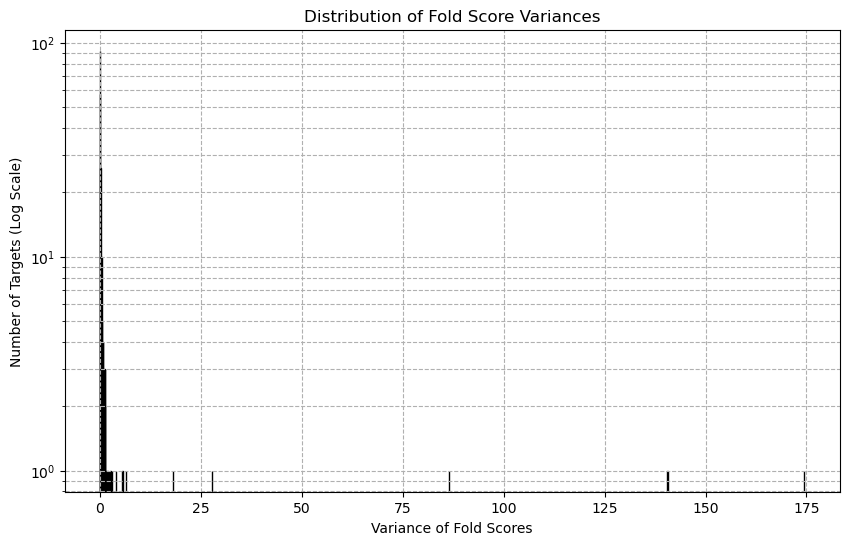

In [35]:
# Calculate the variances of fold scores for each target
variances = [np.var(target_data['all_fold_scores']) for target_data in lasso_results.values()]

# Since we have variances that are very high, we will use a logarithmic scale on the y-axis.
# We also use a wider range of bins to capture the high variance values.

# Find the maximum variance to define the end of the bin range
max_variance = max(variances)

# Define the number of bins or use 'auto' for automatic binning
num_bins = 'auto'  # You can also specify an integer for a fixed number of bins

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(variances, bins=num_bins, edgecolor='black', log=True)  # Note the log=True parameter
plt.title('Distribution of Fold Score Variances')
plt.xlabel('Variance of Fold Scores')
plt.ylabel('Number of Targets (Log Scale)')
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
plt.show()

### exlude the variance > 2 by binning

bins [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ], average bin size 0.05


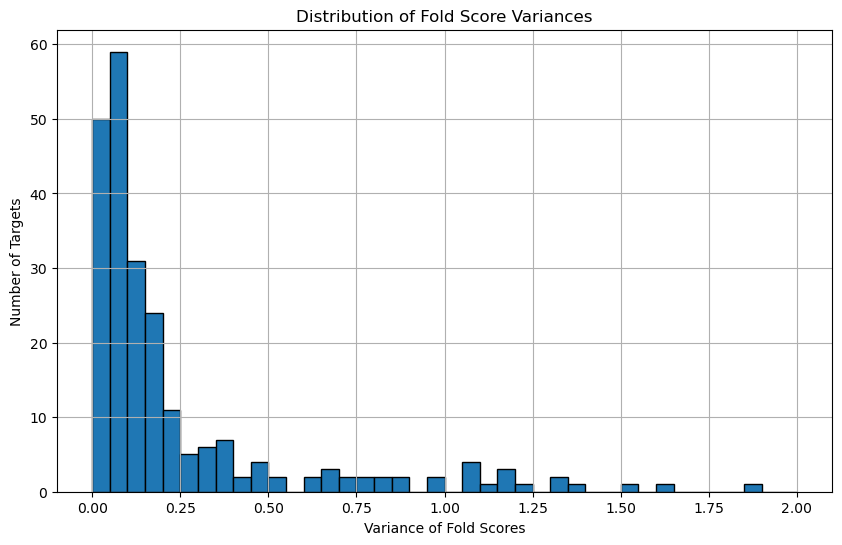

In [38]:


# Plotting the histogram
plt.figure(figsize=(10, 6))
bins=np.arange(0, 2.05, 0.05)
bin_sizes = np.diff(bins)
print(f"bins {bins}, average bin size {np.mean(bin_sizes)}")
plt.hist(variances, bins=bins, edgecolor='black')
plt.title('Distribution of Fold Score Variances')
plt.xlabel('Variance of Fold Scores')
plt.ylabel('Number of Targets')
plt.grid(True)
plt.show()


Bin sizes: [0.16804851 0.16804851 0.16804851 0.16804851 0.16804851 0.16804851
 0.16804851 0.16804851 0.16804851 0.16804851 0.16804851 0.16804851
 0.16804851 0.16804851 0.16804851 0.16804851 0.16804851 0.16804851
 0.16804851 0.16804851 0.16804851 0.16804851 0.16804851 0.16804851
 0.16804851 0.16804851 0.16804851 0.16804851]
Average bin size: 0.1680485120383642


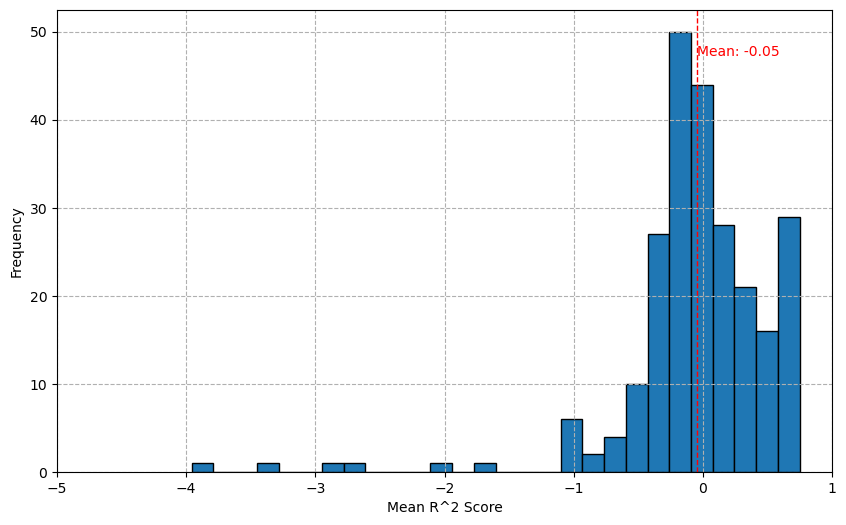

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

all_mean_scores = [lasso_results[target_data]['mean_10x'] for target_data in lasso_results.keys()]
mean_score = np.mean(all_mean_scores)

bin_edges = np.histogram_bin_edges(all_mean_scores, bins='auto')
bin_sizes = np.diff(bin_edges)  # Calculate the bin sizes
print("Bin sizes:", bin_sizes)
average_bin_size = np.mean(bin_sizes)
print("Average bin size:", average_bin_size)
plt.hist(all_mean_scores, bins=bin_edges, edgecolor='black')

# Set the x-axis label
plt.xlabel('Mean R^2 Score')

# Set the y-axis label
plt.ylabel('Frequency')

# Set x-axis ticks
xticks_major = np.arange(-5, max(all_mean_scores) + 1, 1)
plt.xticks(xticks_major)

# Draw a vertical line for the mean score
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1)

# Annotate the mean score
plt.text(mean_score, plt.gca().get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color = 'red')

# Add grid lines
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Display the plot
plt.show()


### exclude target with mean R² < -1

In [41]:
c = 0
# exclude models that are worse than -1
all_mean_scores = [lasso_results[target_data]['mean_10x'] for target_data in lasso_results if lasso_results[target_data]['mean_10x'] > -1]
for target_data in lasso_results:
    if lasso_results[target_data]['mean_10x'] <= -1:
        print(f"{target_data} with mean score\t{round(lasso_results[target_data]['mean_10x'], 3)}")
        c += 1
print(c)


_671_2775803_7_254060113_nXcv with mean score	-1.01
Glutamic_acid_L_nXcv with mean score	-1.015
Dehydro_Ascorbic_acid_L_nXcv with mean score	-3.957
Kaempferol_3_O_glucoside_7_O_r_nXcv with mean score	-2.76
Kaempferol_7_3G_glucosylgentio_nXcv with mean score	-1.984
_D_Glycero_alpha_D_Manno_Hepto_nXcv with mean score	-3.324
Quercetin_glucose_glucose_rham_nXcv with mean score	-1.087
Prolylglycine_L_nXcv with mean score	-1.747
Triterpene_8_14_nXcv with mean score	-2.941
9


Bin sizes: [0.1583119 0.1583119 0.1583119 0.1583119 0.1583119 0.1583119 0.1583119
 0.1583119 0.1583119 0.1583119 0.1583119]
Average bin size: 0.15831190106226306


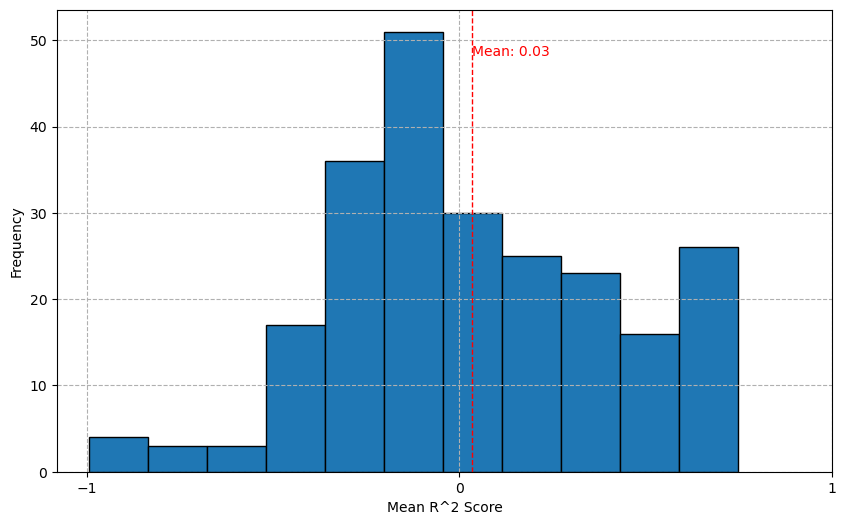

In [42]:
mean_score = np.mean(all_mean_scores)
plt.figure(figsize=(10, 6))
bin_edges = np.histogram_bin_edges(all_mean_scores, bins='auto')
bin_sizes = np.diff(bin_edges)  # Calculate the bin sizes
print("Bin sizes:", bin_sizes)
average_bin_size = np.mean(bin_sizes)
print("Average bin size:", average_bin_size)
plt.hist(all_mean_scores, bins=bin_edges, edgecolor='black')

# Set the x-axis label
plt.xlabel('Mean R^2 Score')

# Set the y-axis label
plt.ylabel('Frequency')

# Set x-axis ticks
xticks_major = np.arange(-1, max(all_mean_scores) + 1, 1)
plt.xticks(xticks_major)

# Draw a vertical line for the mean score
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1)

# Annotate the mean score
plt.text(mean_score, plt.gca().get_ylim()[1]*0.9, f'Mean: {mean_score:.2f}', color = 'red')

# Add grid lines
plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks

# Display the plot
plt.show()
